# 1. package 설치

In [ ]:
! pip install librosa
! pip install pydub
!pip install noisereduce
!pip install transformers
!pip install phonemizer
!pip install dtw-python

!pip install py-espeak-ng
!sudo apt-get install python-espeak
!sudo apt-get update && sudo apt-get install espeak

In [ ]:
# 구글 드라이브 mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. 파일 확장자 변환 및 전처리

In [ ]:
# 전처리 코드
from scipy.io import wavfile
import noisereduce as nr
import IPython
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment

In [ ]:
# wav파일을 read하면서 ndarray가 2차원을 가지게 되는 경우도 생김
## reduced_noise에 넣어 작업하려면 무조건 1차원으로 들어가야 함
## 따라서 2차원 data가 생성되었을 때, 1차원으로 바꾸어주는 작업을 하는 메소드 생성

class DimentionOverflow(Exception):
    def __init__(self):
      pass

    def __str__(self):
      return "The dimention is greater than 2"
      
# 2차원 => 1차원으로 바꿔주는 함수
def convert_dim(data):
  assert type(data) == np.ndarray, "Data type is wrong"
  
  if data.ndim == 1:
    return data
  
  elif data.ndim == 2:
    return data[:, 0]
  
  else:
    raise DimentionOverflow

# wav 변환 method
def to_wav(file_path, file_name):
    audSeg = AudioSegment.from_file(file_path)
    audSeg.export(f"{file_name}.wav", format="wav")
    print(f'{file_name}.wav convert success!')

# noise 제거 작업
def reduce_noise(file_path, file_name):
    rate, data = wavfile.read(file_path)
    data_r = convert_dim(data)

    reduced_noise = nr.reduce_noise(y=data_r, sr=rate)
    wavfile.write(f"{file_name}_reducednoise.wav", rate, reduced_noise)

In [ ]:
from pydub import AudioSegment

# 파일 불러오기
native = "/content/drive/MyDrive/Vinsenjo/Sun/data/voice/voice_ryan.mp3"
speaker = "/content/drive/MyDrive/Vinsenjo/Sun/data/voice/Speak.m4a"

# wav 변환                                                     
to_wav(native, 'voice_ryan')
to_wav(speaker, 'speak')


voice_ryan.wav convert success!
speak.wav convert success!


In [ ]:
# 데이터 로드
path = "/content/speak.wav"

# 발화자의 파일(speak.wav)의 noise reduce
reduce_noise(path, "speak")

# 3. STT 및 Text -> phoneme 변환

In [ ]:
# from transformers.models.wav2vec2_phoneme import tokenization_wav2vec2_phoneme
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer
from phonemizer import phonemize
import torch
import librosa


In [ ]:
# 음원 -> 음소
def speak_to_phoneme(audio, tokenizer, model, is_stress=False):
    assert type(audio) == np.ndarray
    # 유저 발화 파일 tokenizer에 넣기
    input_values = tokenizer(audio, return_tensors = "pt").input_values

    # 모델을 통해 logit값 출력(non_normalized)
    logits = model(input_values).logits

    # argmax를 통해 가장 가능성 높은 logits 들을 예측 logits으로
    prediction = torch.argmax(logits, dim = -1)

    # decoeding해서 text로 변환
    transcription = tokenizer.batch_decode(prediction)[0]

    phoneme = text_to_phoneme(transcription, is_stress)
    return transcription, phoneme


# text -> 음소
def text_to_phoneme(transcription, is_stress=False):
    assert type(transcription) == str
    # 라이브러리를 활용해서 phoneme 변환
    phoneme = phonemize(transcription, with_stress=is_stress).rstrip()
    return phoneme

In [ ]:
# model과 tokenizer pre-trained된 것 가져오기

tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:757: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  FutureWarning,
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# librosa를 통해 load
ans, rate1 = librosa.load("/content/voice_ryan.wav", sr = 16000)
deaf, rate2 = librosa.load("/content/speak.wav", sr = 16000)

In [ ]:
# 음소 변환 작업

ans_transcription = "Hello, my name is Ryan"
ans_phoneme = text_to_phoneme(ans_transcription, is_stress=False)

print('정답')
print(ans_transcription)
print(ans_phoneme, end='\n\n')


deaf_transcription, deaf_phoneme = speak_to_phoneme(deaf, tokenizer, model, is_stress=False)

print('발화자')
print(deaf_transcription)
print(deaf_phoneme)

정답
Hello, my name is Ryan
həloʊ maɪ neɪm ɪz ɹaɪən

발화자
HALLO MY NAME'S ARYON
hæloʊ maɪ neɪmz ɑːɹɪən


In [ ]:
# # 시퀀스 `X[0…m-1]` 및 `Y[0…n-1]`의 가장 긴 공통 부분 문자열을 찾는 함수
# def LCS(X, Y, m, n):
 
#     maxLength = 0           #는 LCS의 최대 길이를 저장합니다.
#     endingIndex = m         #는 `X`에 LCS의 끝 인덱스를 저장합니다.
 
#     # `lookup[i][j]`는 하위 문자열 `X[0…i-1]` 및 `Y[0…j-1]`의 LCS 길이를 저장합니다.
#     lookup = [[0 for x in range(n + 1)] for y in range(m + 1)]
 
#     # 상향식 방식으로 조회 테이블 채우기
#     for i in range(1, m + 1):
#         for j in range(1, n + 1):
 
#             # `X`와 `Y`의 현재 문자가 일치하는 경우
#             if X[i - 1] == Y[j - 1]:
#                 lookup[i][j] = lookup[i - 1][j - 1] + 1
 
#                 #는 최대 길이와 끝 인덱스를 업데이트합니다.
#                 if lookup[i][j] > maxLength:
#                     maxLength = lookup[i][j]
#                     endingIndex = i

#     #는 길이가 `maxLength`인 가장 긴 공통 부분 문자열을 반환합니다.
#     return X[endingIndex - maxLength: endingIndex]
 


# X = ans_phonemes
# Y = deaf_phonemes

# m = len(X)
# n = len(Y)

# # 가장 긴 공통 부분 문자열 찾기
# print('The longest common substring is', LCS(X, Y, m, n))

In [ ]:
# LCS 알고리즘을 사용하여 두 string 중에서 겹치는 음소 subsequence 출력 용도
def lcs_algo(S1, S2, m, n):
    L = [[0 for x in range(n+1)] for x in range(m+1)]

    # bottom-up 방식으로 matrix 쌇아감
    for i in range(m+1):
        for j in range(n+1):
            if i == 0 or j == 0:
                L[i][j] = 0
            elif S1[i-1] == S2[j-1]:
                L[i][j] = L[i-1][j-1] + 1
            else:
                L[i][j] = max(L[i-1][j], L[i][j-1])

    index = L[m][n]

    lcs_algo = [""] * (index+1)
    lcs_algo[index] = ""

    i = m
    j = n
    while i > 0 and j > 0:

        if S1[i-1] == S2[j-1]:
            lcs_algo[index-1] = S1[i-1]
            i -= 1
            j -= 1
            index -= 1

        elif L[i-1][j] > L[i][j-1]:
            i -= 1
        else:
            j -= 1
            
    #  subsequences 출력
    print("S1 : " + S1 + "\nS2 : " + S2)

    lcs = "".join(lcs_algo)
    print("LCS: " + lcs)

    return lcs

# 정확도 및 score 반환
def calculate_acc(ans, lcs):
    accuracy = int(len(lcs) / len(ans) * 100)
    score = ""

    # 일단 단계는 임의로 둠
    if accuracy == 100:
        score = "Perfect"
    elif accuracy >= 80:
        score = "Great"
    elif accuracy >= 60:
        score == "Good"
    else:
        score == "Try Again"

    return accuracy, score

# 정답 음소와 발화자의 음소 중, 일치하는 음소 구분해서 출력해주는 함수
def highlight(ans, lcs):
    
  # answer phonemes중에 틀린것은 0, 일치하는 것은 1로 두어, 0인것은 나중에 틀린것 표시하기 위함
  correct = [[i, 0] for i in ans]
  idx=0

  # lcs에서 하니씩 음소를 가져와서 answer과 비교함
  ## 일치하면 correct의 해당 음소의 값을 0에서 1로
  for char in lcs:
      while idx < len(ans):
          tmp = ans[idx]

          if tmp == char:
              correct[idx][1] = 1
              idx += 1
              break
          idx += 1
    
  return correct

In [ ]:
S1 = ans_phoneme
S2 = deaf_phoneme
m = len(S1)
n = len(S2)
lcs = lcs_algo(S1, S2, m, n)

S1 : həloʊ maɪ neɪm ɪz ɹaɪən
S2 : hæloʊ maɪ neɪmz ɑːɹɪən
LCS: hloʊ maɪ neɪmz ɹɪən


In [ ]:
print(S1)
print(lcs)

həloʊ maɪ neɪm ɪz ɹaɪən
hloʊ maɪ neɪmz ɹɪən


In [ ]:
highlight(S1, lcs)

[['h', 1],
 ['ə', 0],
 ['l', 1],
 ['o', 1],
 ['ʊ', 1],
 [' ', 1],
 ['m', 1],
 ['a', 1],
 ['ɪ', 1],
 [' ', 1],
 ['n', 1],
 ['e', 1],
 ['ɪ', 1],
 ['m', 1],
 [' ', 0],
 ['ɪ', 0],
 ['z', 1],
 [' ', 1],
 ['ɹ', 1],
 ['a', 0],
 ['ɪ', 1],
 ['ə', 1],
 ['n', 1]]

In [ ]:
calculate_acc(S1, lcs)

(82, 'Great')

# wave -> energy추출해서 rms함 (mel_spectrogram 활용하는 방법은 미완료)
- 다음과 같이 pitch를 추출할 수 있지 않을까??

In [ ]:
# rms 값 추출
rms1 = librosa.feature.rms(ans)
rms2 = librosa.feature.rms(deaf)


In [ ]:
print(rms1)
print(rms2)
print(rms1.shape, rms2.shape)

[[0.00203968 0.0067128  0.01032178 0.01091102 0.01152461 0.01096799
  0.01103355 0.05072284 0.07122253 0.08421919 0.09647362 0.09710042
  0.10971522 0.11995935 0.12544332 0.12900326 0.11566131 0.10121255
  0.08597396 0.06441206 0.04866615 0.03352183 0.01954649 0.01477945
  0.0150562  0.01705156 0.01866503 0.01878586 0.01875058 0.01706527
  0.01471047 0.01971043 0.04354456 0.06557201 0.08102518 0.09158603
  0.09359498 0.0900062  0.08877462 0.08838863 0.09045454 0.09255739
  0.09484968 0.09857534 0.10064265 0.10543782 0.10480142 0.10650429
  0.10621103 0.10004933 0.09411085 0.08025015 0.06416893 0.05110247
  0.04309841 0.0517555  0.06784407 0.08193312 0.09269603 0.09693376
  0.09518456 0.09113561 0.08640597 0.07723404 0.06786294 0.05608563
  0.04380947 0.03570864 0.02721903 0.02243662 0.01639701 0.01338314
  0.01176038 0.01062211 0.01162807]]
[[0.00073582 0.00284634 0.00741056 0.00812109 0.00832278 0.00802477
  0.00467688 0.0052097  0.01186728 0.01340196 0.01414921 0.01361367
  0.0082929

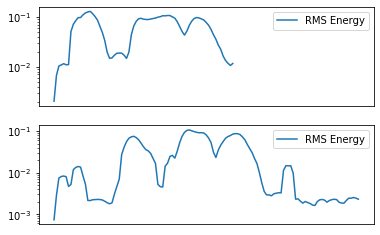

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(rms1)
ax[0].semilogy(times, rms1[0], label='RMS Energy')
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()

times = librosa.times_like(rms2)
ax[1].semilogy(times, rms2[0], label='RMS Energy')
ax[1].set(xticks=[])
ax[1].legend()
ax[1].label_outer()
# librosa.specshow(librosa.amplitude_to_db(S, ref=np.max),
#                          y_axis='log', x_axis='time', ax=ax[1])
# ax[1].set(title='log Power spectrogram')

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



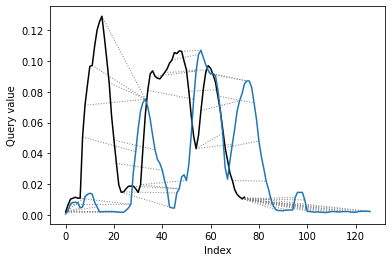

In [ ]:
import dtw
dtw.dtw(rms1.flatten(), rms2.flatten(), keep_internals=True).plot(type='twoway')

In [ ]:
alignment = dtw.dtw(rms1.flatten(), rms2.flatten(), keep_internals=True)
alignment


DTW alignment object of size (query x reference): 75 x 127

In [ ]:
def downsample(a, b):
    a, b = a.flatten(), b.flatten()
    if len(a) > len(b):
        target, compare = a, b
    else:
        target, compare = b, a

    sampled_list = []
    window_size = len(target) - len(compare) + 1
    for i in range(len(compare)):
        tmp = np.mean(target[i:i+window_size])
        sampled_list.append(tmp)
        
    return np.array(sampled_list)

In [ ]:
import math

# 두 개의 다른 signal 길이 맞춰주는 함수 고안
def downsample(a, b):
    a, b = a.flatten(), b.flatten()
    if len(a) > len(b):
        target, compare = a, b
    else:
        target, compare = b, a

  # 정규화
    norm = np.linalg.norm(target)
    target = target/norm

    norm = np.linalg.norm(compare)
    compare = compare/norm

    sampled_list = []
    padding_size = int(len(target) / len(compare))
    print(padding_size)
    if padding_size > 1:
        for i in range(0, len(target), padding_size):
            tmp = np.mean( target[i:i+padding_size] )
            sampled_list.append(tmp)
    else:
        per = np.percentile(target, 100 - len(compare)/len(target)*100)
        print('percentile')
        print(len(compare)/len(target))
        print(per)
        sampled_list = target[(target > per)]

    return compare, np.array(sampled_list)

In [ ]:
a = np.array([1,2,3,4,5,6,7,8, 9, 10])
b = np.array([1,2,3,4])

new_rms1, new_rms2 = downsample(rms1, rms2)
new_rms2.shape

1
percentile
0.5905511811023622
0.009956278926216242


(75,)

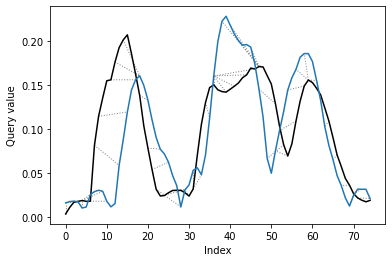

In [ ]:
new_alignment = dtw.dtw(new_rms1.flatten(), new_rms2.flatten(), keep_internals=True)
new_alignment.plot(type='twoway')

In [ ]:
new_alignment.normalizedDistance

0.010025264693734546

In [ ]:
new_rms2

array([0.01581194, 0.017328  , 0.01775836, 0.01712249, 0.00997909,
       0.01111596, 0.02532126, 0.02859582, 0.03019023, 0.02904755,
       0.01769459, 0.01131235, 0.01496271, 0.0584983 , 0.08772027,
       0.11922725, 0.14415172, 0.15595229, 0.16039965, 0.14943773,
       0.13269882, 0.1103483 , 0.09024729, 0.07697292, 0.07151387,
       0.06211338, 0.04699102, 0.03551172, 0.01116048, 0.03056663,
       0.03628165, 0.05283019, 0.0558257 , 0.04786409, 0.07035855,
       0.11227829, 0.16022757, 0.19935304, 0.22233763, 0.2281731 ,
       0.21801068, 0.2080237 , 0.20052752, 0.19517647, 0.19594146,
       0.19309402, 0.17373699, 0.14525937, 0.11321089, 0.06634749,
       0.0495933 , 0.07500207, 0.09813888, 0.1197558 , 0.14425753,
       0.15821975, 0.16775653, 0.18150249, 0.18570812, 0.18564506,
       0.17664175, 0.15513533, 0.13235648, 0.10258181, 0.08115558,
       0.06491961, 0.04686777, 0.03558727, 0.02157078, 0.01222321,
       0.02426273, 0.03148371, 0.03131492, 0.03132994, 0.02087